In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [2]:
movie_data = pd.read_csv('movie_dataset_cleaned_with_profits.csv')

In [3]:
# Convert runtimeMinutes to numeric, coerce errors to handle non-numeric values
movie_data['runtimeMinutes'] = pd.to_numeric(movie_data['runtimeMinutes'], errors='coerce')

In [4]:
# Drop Movies that have 0 revenue and runtimeMin and movies before 2000
movie_data = movie_data[(movie_data['revenue'] > 0) & (movie_data['runtimeMinutes'] > 0) & (movie_data['startYear'] > 2000)]

In [5]:
# Changing units of revenue to be in the millions for easier readibility 
movie_data['revenue'] = movie_data['revenue'] / 1000000

In [6]:
# Replace \\N fields in each row with NaN and drop the row
movie_data_clean = movie_data.replace('\\N', np.nan).dropna()

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# Add encoded genres back to the dataframe
encoder = OneHotEncoder(sparse_output=False)
genres_encoded = encoder.fit_transform(movie_data_clean[['genres']])
encoded_genres_df = pd.DataFrame(genres_encoded, columns=encoder.get_feature_names_out(['genres']))
movie_data_clean = pd.concat([movie_data_clean.reset_index(drop=True), encoded_genres_df.reset_index(drop=True)], axis=1)

In [8]:
movie_data_clean.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,budget,revenue,profit,...,"genres_Mystery,Romance,Thriller","genres_Mystery,Sci-Fi","genres_Mystery,Sci-Fi,Thriller","genres_Mystery,Thriller",genres_Romance,genres_Sci-Fi,"genres_Sci-Fi,Thriller",genres_Sport,genres_Thriller,genres_War
0,tt0035423,Kate & Leopold,2001.0,118.0,"Comedy,Fantasy,Romance",6.4,89379,48000000.0,76.019048,28019048.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0118589,Glitter,2001.0,104.0,"Drama,Music,Romance",2.4,24128,22000000.0,5.271666,-16728334.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0120667,Fantastic Four,2005.0,106.0,"Action,Adventure,Fantasy",5.7,345082,100000000.0,333.535934,233535934.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0120681,From Hell,2001.0,122.0,"Horror,Mystery,Thriller",6.7,164851,35000000.0,74.558115,39558115.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0120737,The Lord of the Rings: The Fellowship of the Ring,2001.0,178.0,"Action,Adventure,Drama",8.9,2021654,93000000.0,871.368364,778368364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Select relevant features for the model
features = ['startYear', 'runtimeMinutes', 'averageRating', 'numVotes', 'budget'] + list(encoded_genres_df.columns)
X = movie_data_clean[features]
y = movie_data_clean['revenue']

In [10]:
# Using 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
# Train a Random Forest Regressor
model = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(n_estimators=200, random_state=40)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
# Fit a linear regression model for Random Forest predictions
linear_reg_rf = LinearRegression()
linear_reg_rf.fit(y_test.values.reshape(-1, 1), y_pred)
slope = linear_reg_rf.coef_[0]
intercept = linear_reg_rf.intercept_

In [13]:
# show prediction scores for training and testing
model.score(X_train, y_train)

0.9656407586696092

In [14]:
model.score(X_test, y_test)

0.763867123275779

Text(0.5, 1.0, 'Random Forest: Actual vs Predicted Revenue')

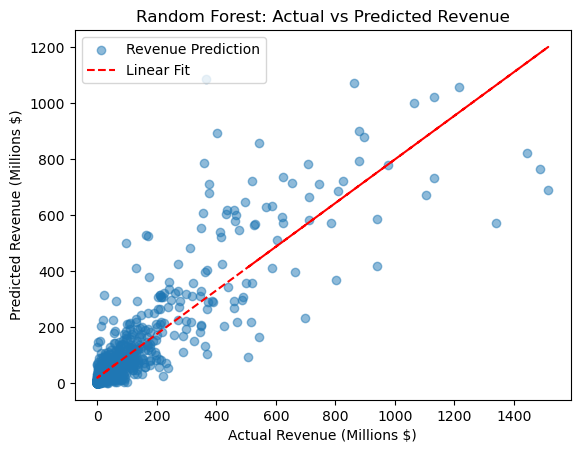

In [15]:
# plot the predictions and linear regression 
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(y_test, y_test * slope + intercept, '--', color='red')
plt.xlabel('Actual Revenue (Millions $)')
plt.ylabel('Predicted Revenue (Millions $)')
plt.legend(['Revenue Prediction', 'Linear Fit'], loc="upper left")
plt.title('Random Forest: Actual vs Predicted Revenue')